In [5]:
import numpy as np
import pandas as pd
import random

from pathlib import Path
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.metrics import AUC
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GRU, Input, BatchNormalization, Dropout, LSTM
from ncps.wirings import AutoNCP
from ncps.keras import LTC

# Configuration

In [6]:
NUM_EPOCHS = 85
NUM_EXPERIMENTS = 1

def create_model(train):
    model = Sequential()
    model.add(Input(shape=(train.shape[1], train.shape[2])))

    model.add(Dropout(0.2))
    model.add(LSTM(10, return_sequences=True))

    model.add(Dropout(0.2))
    model.add(LSTM(10, return_sequences=True))

    model.add(Dropout(0.2))
    model.add(LSTM(10, return_sequences=False))

    model.add(Dropout(0.2))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=0.003), loss='binary_crossentropy', metrics=["accuracy", AUC(name="auc")])
    return model

# Experiment

In [7]:
ID = ["ID"]
USER = ["SubjectID"]
IDS = ["SubjectID", "VideoID"]
TARGET = ["predefinedlabel"]
FEATURES = ["Delta", "Theta", "Alpha1", "Alpha2", "Beta1", "Beta2", "Gamma1", "Gamma2"]
INIT_SEED = 6412

In [8]:
data_dir = Path("/home/aseliverstov/projects/brain_signals/data")
data = pd.read_csv(data_dir / "EEG_data.csv")

data["ID"] = (len(np.unique(data["VideoID"])) * data["SubjectID"] + data["VideoID"]).astype("int")
data = data[ID + USER + FEATURES + TARGET]

data.head(3)

,ID,SubjectID,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel
0,0,0.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0
1,0,0.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0
2,0,0.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0


In [9]:
def reshape_dataset(data):
    features = []
    target = []
    for cur_id in np.unique(data[ID].to_numpy()):
        cur_id_data = data[data[ID].to_numpy() == cur_id]
        target.append(np.mean(cur_id_data[TARGET].to_numpy()).astype("int"))
        features.append(cur_id_data[FEATURES].to_numpy())

    features = pad_sequences(features)
    return np.array(features), np.array(target)

def pad_sequences(arrays, pad_value=0):
    max_length = max(arr.shape[0] for arr in arrays)
    padded_arrays = [
        np.pad(
            arr,
            ((0, max_length - arr.shape[0]), (0, 0)),
            mode='constant',
            constant_values=pad_value)
            for arr in arrays
        ]
    return np.stack(padded_arrays)

In [10]:
X, _ = reshape_dataset(data)
model = create_model(X)
model.summary()

2025-04-02 22:47:01.006945: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ (None, 144, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 144, 10)        │           760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 144, 10)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 144, 10)        │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 144, 10)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 10)             │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │            66 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,513 (9.82 KB)

 Trainable params: 2,513 (9.82 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
%%time

all_acc = []
all_loss = []
all_auc = []

all_val_acc = []
all_val_loss = []
all_val_auc = []

for j, seed in tqdm(enumerate(np.arange(NUM_EXPERIMENTS) + INIT_SEED)):
    np.random.seed(int(seed))
    random.seed(int(seed))
    tf.random.set_seed(int(seed))

    train_id = np.random.choice(np.unique(np.ravel(data[USER])), 7, replace=False)
    train_index = np.isin(data[USER], train_id)

    train = data.iloc[train_index]
    test = data.iloc[~train_index]

    X_train, y_train = reshape_dataset(train)
    X_test, y_test = reshape_dataset(test)

    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    model = create_model(X_train)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=NUM_EPOCHS,
        batch_size=10,
        verbose=1,
    )

    acc = history.history['accuracy']
    loss = history.history['loss']
    auc = history.history['auc']

    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    val_auc = history.history['val_auc']

    all_acc.append(acc)
    all_loss.append(loss)
    all_auc.append(auc)

    all_val_acc.append(val_acc)
    all_val_loss.append(val_loss)
    all_val_auc.append(val_auc)

epoch_acc = np.mean(all_acc, axis=0)
epoch_loss = np.mean(all_loss, axis=0)
epoch_auc = np.mean(all_auc, axis=0)

epoch_val_acc = np.mean(all_val_acc, axis=0)
epoch_val_loss = np.mean(all_val_loss, axis=0)
epoch_val_auc = np.mean(all_val_auc, axis=0)


0it [00:00, ?it/s]

Epoch 1/85
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.3856 - auc: 0.3121 - loss: 0.6970 - val_accuracy: 0.5000 - val_auc: 0.5556 - val_loss: 0.6916
Epoch 2/85
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.4903 - auc: 0.6323 - loss: 0.6908 - val_accuracy: 0.6333 - val_auc: 0.7444 - val_loss: 0.6838
Epoch 3/85
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.6543 - auc: 0.6829 - loss: 0.6807 - val_accuracy: 0.6667 - val_auc: 0.7156 - val_loss: 0.6605
Epoch 4/85
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.5681 - auc: 0.6941 - loss: 0.6626 - val_accuracy: 0.7000 - val_auc: 0.6844 - val_loss: 0.6169
Epoch 5/85
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.6932 - auc: 0.7261 - loss: 0.6173 - val_accuracy: 0.7000 - val_auc: 0.6800 - val_loss: 0.5798
Epoch 6/85
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.6959 - auc: 0.6578 - loss: 0.5807 - val_accuracy: 0.7667 - val_auc: 0.7200 - val_loss: 0.5326
Epoch 7/85
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accur

1it [01:31, 91.59s/it]

CPU times: user 3min 9s, sys: 1min 13s, total: 4min 23s
Wall time: 1min 31s


In [13]:
for i in range(NUM_EPOCHS):
    print(f"Epoch {(i + 1)}: TRAIN Accuracy = {np.round(epoch_acc[i], 3)} Loss = {np.round(epoch_loss[i], 3)} AUC = {np.round(epoch_auc[i], 3)}")
    print(f"Epoch {(i + 1)}: VAL Accuracy = {np.round(epoch_val_acc[i], 3)} Loss = {np.round(epoch_val_loss[i], 3)} AUC = {np.round(epoch_val_auc[i], 3)}")

Epoch 1: TRAIN Accuracy = 0.4 Loss = 0.696 AUC = 0.358
Epoch 1: VAL Accuracy = 0.5 Loss = 0.692 AUC = 0.556
Epoch 2: TRAIN Accuracy = 0.557 Loss = 0.69 AUC = 0.625
Epoch 2: VAL Accuracy = 0.633 Loss = 0.684 AUC = 0.744
Epoch 3: TRAIN Accuracy = 0.686 Loss = 0.676 AUC = 0.744
Epoch 3: VAL Accuracy = 0.667 Loss = 0.661 AUC = 0.716
Epoch 4: TRAIN Accuracy = 0.671 Loss = 0.648 AUC = 0.753
Epoch 4: VAL Accuracy = 0.7 Loss = 0.617 AUC = 0.684
Epoch 5: TRAIN Accuracy = 0.743 Loss = 0.591 AUC = 0.795
Epoch 5: VAL Accuracy = 0.7 Loss = 0.58 AUC = 0.68
Epoch 6: TRAIN Accuracy = 0.743 Loss = 0.54 AUC = 0.761
Epoch 6: VAL Accuracy = 0.767 Loss = 0.533 AUC = 0.72
Epoch 7: TRAIN Accuracy = 0.757 Loss = 0.507 AUC = 0.792
Epoch 7: VAL Accuracy = 0.767 Loss = 0.511 AUC = 0.758
Epoch 8: TRAIN Accuracy = 0.771 Loss = 0.492 AUC = 0.836
Epoch 8: VAL Accuracy = 0.8 Loss = 0.474 AUC = 0.791
Epoch 9: TRAIN Accuracy = 0.786 Loss = 0.469 AUC = 0.845
Epoch 9: VAL Accuracy = 0.8 Loss = 0.461 AUC = 0.813
Epoch 10:

In [57]:
import numpy as np
import shap
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.lines as mlines

def plot_time_series_with_shap(model, X_train, X_test, y_test, j, feature_names):
    X_sample, y_sample = X_test[j], y_test[j]
    background = X_train

    explainer = shap.GradientExplainer(model, background)
    shap_values = explainer.shap_values(np.expand_dims(X_sample, axis=0))[0]
    shap_values = np.squeeze(shap_values)

    shap_mean = np.mean(shap_values)

    plt.figure(figsize=(15, 8))
    num_features = X_sample.shape[1]
    red_colors = cm.Reds(np.linspace(0.2, 0.9, num_features))  # More color variation in red
    blue_colors = cm.Blues(np.linspace(0.2, 0.9, num_features))  # More color variation in blue
    
    scatter_plots = []
    for i in range(num_features):
        cur_feature_shap_values = shap_values[:, i] / shap_mean
        ts = np.arange(X_sample.shape[0])
        c = [red_colors[i] if el > 0 else blue_colors[i] for el in cur_feature_shap_values]
        s = [2 * np.abs(el) if 2 * np.abs(el) > 0.5 else 0.5 for el in cur_feature_shap_values]
        
        plt.scatter(ts, X_sample[:, i], color=c, s=s)
        scatter_plots.append((red_colors[i], blue_colors[i], feature_names[i]))
    
    raw_prediction = model.predict(np.expand_dims(X_sample, axis=0))
    prediction = 'Confused' if raw_prediction > 0.5 else 'Not Confused'
    plt.yscale('log')
    plt.xlabel("Timestep")
    plt.ylabel("Feature Value (Log Scale)")
    
    # Custom legend with both blueish and reddish markers
    legend_handles = [
        mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor=red, markersize=5, label=name)
        for red, blue, name in scatter_plots
    ] + [
        mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor=blue, markersize=5)
        for _, blue, _ in scatter_plots
    ]
    legend_labels = [name for _, _, name in scatter_plots] + ["" for _ in scatter_plots]
    
    plt.legend(handles=legend_handles, labels=legend_labels, loc="upper right", ncol=2, handletextpad=1.5)
    plt.title(f"Sample {j}. True value '{'Confused' if y_sample == 1 else 'Not Confused'}'. Predicted '{prediction}': {np.round(raw_prediction, 2)}%")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


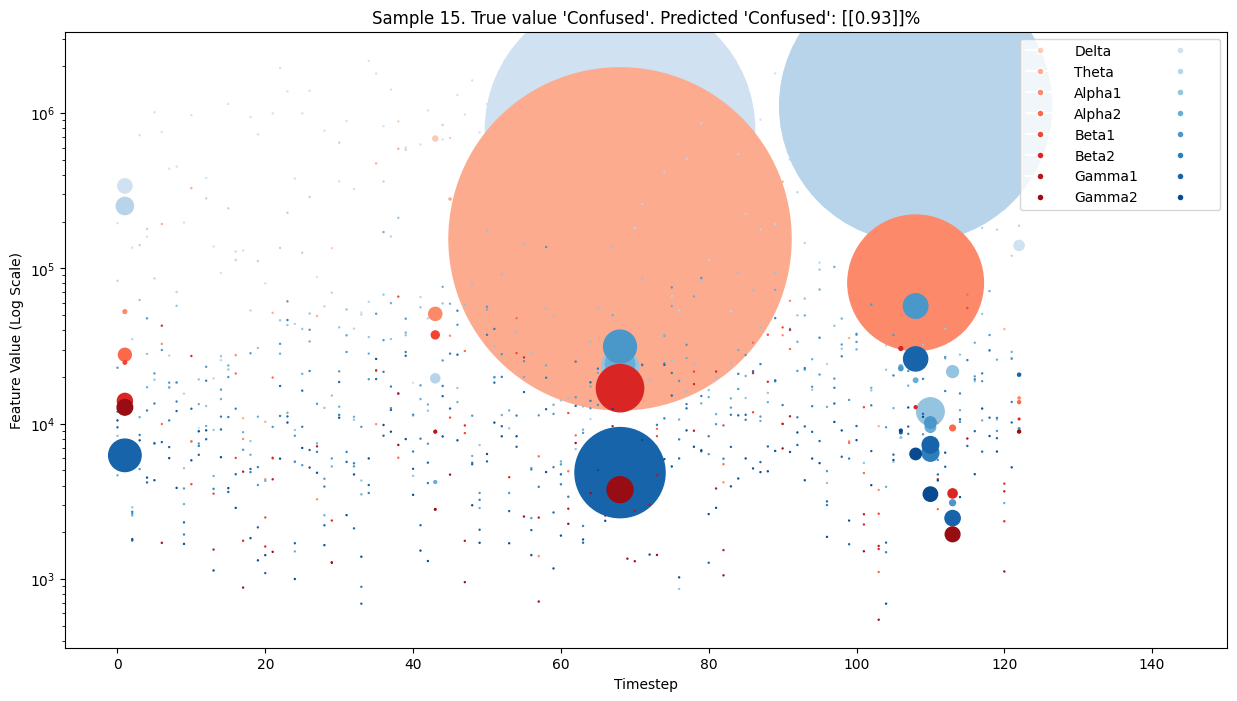

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


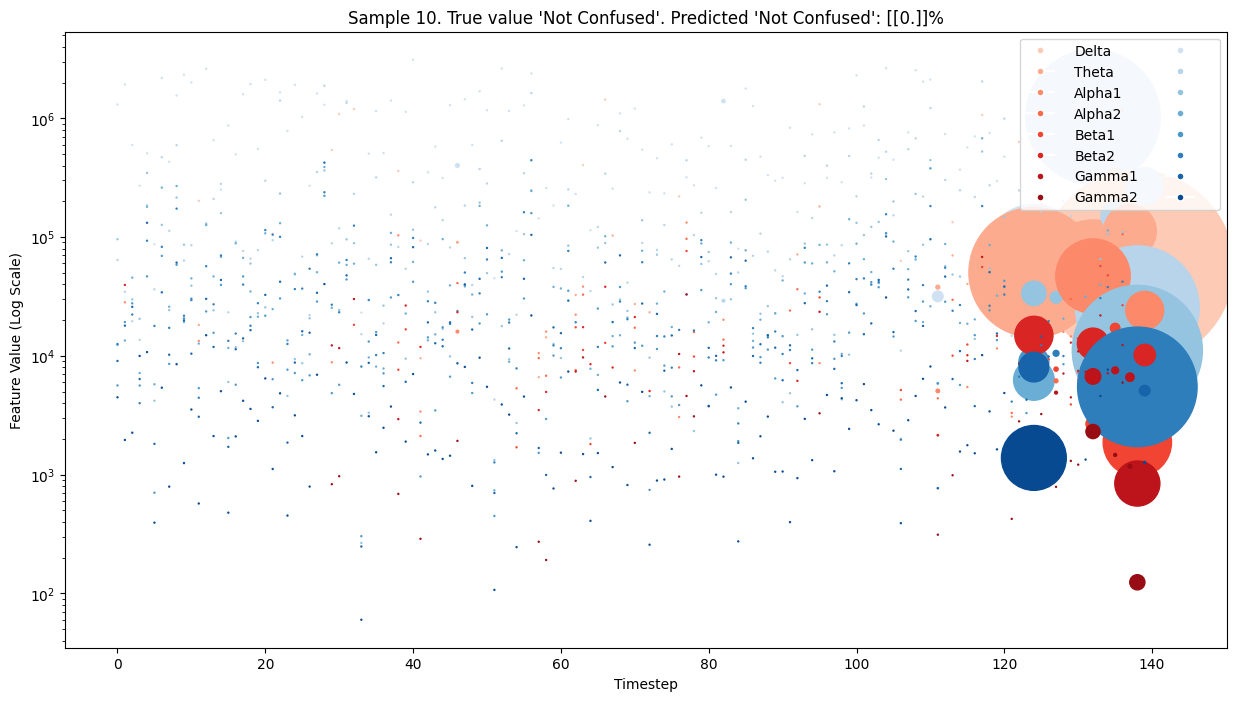

In [56]:
plot_time_series_with_shap(model, X_train, X_test, y_test, 15, FEATURES)
plot_time_series_with_shap(model, X_train, X_test, y_test, 10, FEATURES)